# Import Statements

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from copy import deepcopy
import numpy as np
import statsmodels.api as sm
import random
import ast
from datetime import datetime

from graph_util.visualization_util import make_graph_visual
from graph_util.random_graph_functions import random_all_fork, random_all_join
from scheduling_util.modified_etf import Mod_ETF
from scheduling_util.consolidated_functions import opt_schedule_given_ordering
from scheduling_util.heuristics import *
from graph_util.random_graph_functions import random_all_fork, random_all_join
from graph_util.erdos_renyi_dag import er_dag
from scheduling_util.approx_pseudosizes import speed_to_psize


# Training Data

In [2]:
# Function to get list of feature sets. A feature set is in the form [x1, x2, ..., y] where y is psize
def get_feature_set(G):
    lst = []
    
    # Get attributes for graph G
    out_bet_lst = nx.algorithms.out_degree_centrality(G)
    trophic_lst = nx.algorithms.trophic_levels(G)
    
    # Create feature set for each node in G
    for node in G.nodes:
        out_bet = out_bet_lst[node]
        trophic = trophic_lst[node]
        descendants = list(nx.algorithms.dag.descendants(G, node))
        descendants.append(node)
        
        lst.append({
            "constant": 1,
            "num_descendants": float(len(descendants)),
            "trophic_levels": float(trophic),
        })   
        
    return lst

#             "out_degree_betweenness_centrality": float(out_bet),
#'out_degree_betweenness_centrality',

Create training data with given parameters

In [3]:
def reset_psizes(psizes):
    revised_lst = [abs(x) for x in psizes]
    assert(all([z > 0 for z in revised_lst]))
    return revised_lst

# Function to create dataset
def create_dataset(num_machines, csv_file):
    
    df = pd.DataFrame(columns = [
        "graph_object",
        "num_tasks",
        "num_machines",
        "weights",
        "order",
        "features",
        "psize",
        "GD_cost",
        "LR_cost",
        "RLP_cost",
        "ETF-H_cost",
        "weak_strongman_cost"
    ])
    tie_breaking_rule = 2
    count = 0

    csv_df = pd.read_csv(csv_file) 
    count = 0
    for index, row in csv_df.iterrows():
        
        dict_dag = ast.literal_eval(row["graph_object"])
        G = nx.node_link_graph(dict_dag)

        num_tasks = len(G)
        
        _, _, h1_cost, _ = heuristic_algorithm(G, num_machines)
        w = [1 for _ in range(num_tasks)]
        s = [1 for _ in range(num_tasks)]
        p = [1 for _ in range(num_tasks)]
        etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
        weak_strongman_cost = naive_2(G, num_machines)
        intervals, speeds, opt_cost = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
        if speeds[0] != -1:
            entry_dict = {
                "graph_object": nx.node_link_data(G),
                "num_tasks": num_tasks,
                "num_machines": num_machines,
                "weights": w,
                "order": etf.order,
                "features": get_feature_set(G),
                "psize": speed_to_psize(speeds),
                "GD_cost": np.inf,
                "LR_cost": np.inf,
                "RLP_cost": opt_cost,
                "ETF-H_cost": h1_cost,
                "weak_strongman_cost": weak_strongman_cost
            }
            df = df.append(entry_dict, ignore_index = True)
            print(count)
            count += 1
                    
    return df


# Train Model

In [4]:
def compute_cost(w, t, s):
    '''
    Given weights w, time intervals t, and speeds s, compute the cost of the schedule; 
    returns total cost as well as separate power and time components.
    '''
    power = 0
    time = 0
    #print(f"compute cost intervals are {t}")
    for j in range(len(s)):
        if t[j] == -1:
            return -1, -1, -1
        power += w[j] * s[j]
        time += t[j][1]
    total_cost = power + time
    return total_cost, power, time

def psize_to_speed(psize):
    return [np.sqrt(psize[i]) for i in range(len(psize))]

#predict list of psizes for one graph G
def predict(coef, features):
    m = []
    for f in features:
        m.append(list(f.values()))
    return np.matmul(m, coef)

In [5]:
# Functions for Gradient Descent Approach
def single_weight_update(coef, G, w, features, order, curr_cost, step_size):
    
    m = []
    for f in features:
        m.append(list(f.values()))
        
    curr_min_coef = deepcopy(coef)
    min_cost = curr_cost
    all_combinations = list(product((-1, 1, 0), repeat=len(coef)))
    for combo in all_combinations:
        temp_coef = deepcopy(coef)
        for i in range(len(combo)):
            temp_coef[i] += step_size * combo[i]
        psizes = reset_psizes(np.matmul(m, temp_coef))
        speeds = psize_to_speed(psizes)
        time_intervals = native_rescheduler(deepcopy(G), deepcopy(speeds), deepcopy(w), deepcopy(order))
        cost, _, _ = compute_cost(w, time_intervals, speeds)
        if cost < min_cost:
            min_cost = cost
            curr_min_coef = deepcopy(temp_coef)
        
    return min_cost, curr_min_coef


In [6]:
def gd_algorithm(lr_coefficients, df):
    MAX_ITER = 50
    step_size = 0.05
    i = 0
    
    coef = lr_coefficients

    stopping_condition = 0.01

    #iterate until the objective function cost change lowers to stopping point
    while i < MAX_ITER:

        cost_lst = []
        max_change = - np.infty
        for index, row in df.iterrows():
            new_cost, new_coef = single_weight_update(
                coef, 
                nx.node_link_graph(row["graph_object"]),
                row["weights"], 
                row["features"], 
                row["order"],
                row["GD_cost"],
                step_size
            )

            if row["GD_cost"] == np.inf: 
                change = - np.inf

            else:
                change = row["GD_cost"] - new_cost

            cost_lst.append(new_cost)
            max_change = max(change, max_change)
            coef = new_coef
        print(max_change)

        # update costs
        new_df = pd.DataFrame({'GD_cost': cost_lst})
        df.update(new_df)
        if max_change < stopping_condition and i > 1:
            print("Hit stopping condition with ", max_change)
            break
        i += 1
    
    return df, coef

In [7]:
def train_model(df_train):
    feature_id = ['constant', 'num_descendants', 'trophic_levels']    
    
    # Create X, Y dataset
    df_features = pd.DataFrame(columns = feature_id)
    df_psize = pd.DataFrame(columns = ["psize"])
    for index, row in df_train.iterrows():
        for feature in row["features"]:
            df_features = df_features.append(feature, ignore_index=True)
        for psize in row["psize"]:
            df_psize = df_psize.append({"psize": psize}, ignore_index=True)   
    X = df_features[feature_id]
    Y = df_psize[["psize"]]

    # Train LR model 
    model=sm.OLS(Y, X.astype(float)).fit()
    print_model=model.summary()
    lr_coefficients = np.array(model.params) # weights learned from LR

    # Get LR cost results on training data 
    lr_lst = []
    for index, row in df_train.iterrows():
        # predict using LR model
        psizes = reset_psizes(predict(lr_coefficients, row["features"]))
        speeds = psize_to_speed(psizes)
        G = nx.node_link_graph(row["graph_object"])
        time_intervals = native_rescheduler(deepcopy(G), deepcopy(speeds), deepcopy(row["weights"]), deepcopy(row["order"]))
        cost, power, time = compute_cost(row["weights"], time_intervals, speeds)
        lr_lst.append(cost)

    new_df = pd.DataFrame({'LR_cost': lr_lst})
    df_train.update(new_df) # update costs on training data

    # for initialization purposes only
    new_df = pd.DataFrame({'GD_cost': lr_lst})
    df_train.update(new_df)
    
    # Get GR cost results on training data
    df_train_results, gd_coefficients = gd_algorithm(lr_coefficients, df_train)
    
    return df_train_results, lr_coefficients, gd_coefficients


# Set Trained Coefficients to linear model

# Test the Model

This section tests the model using the coefficients found above.

In [8]:
def test_model(num_machines, testing_data_filename, lr_coefficients, gd_coefficients):
    # Create and retrieve costs of test data
    df_test = create_dataset(num_machines, testing_data_filename)
    lr_lst = []
    gd_lst = []
    for index, row in df_test.iterrows():
        G = nx.node_link_graph(row["graph_object"])

        # predict using LR model
        psizes_lr = reset_psizes(predict(lr_coefficients, row["features"]))
        speeds_lr = psize_to_speed(psizes_lr)
        time_intervals_lr = native_rescheduler(deepcopy(G), deepcopy(speeds_lr), deepcopy(row["weights"]), deepcopy(row["order"]))
        cost_lr, power_lr, time_lr = compute_cost(row["weights"], time_intervals_lr, speeds_lr)
        lr_lst.append(cost_lr)

        # predict using GD model
        psizes_gd = reset_psizes(predict(gd_coefficients, row["features"]))
        speeds_gd = psize_to_speed(psizes_gd)
        time_intervals_gd = native_rescheduler(deepcopy(G), deepcopy(speeds_gd), deepcopy(row["weights"]), deepcopy(row["order"]))
        cost_gd, power_gd, time_gd = compute_cost(row["weights"], time_intervals_gd, speeds_gd)
        gd_lst.append(cost_gd)


    new_df_lr = pd.DataFrame({'LR_cost': lr_lst})
    df_test.update(new_df_lr) # update costs on test data

    # for initialization purposes only
    new_df_gd = pd.DataFrame({'GD_cost': lr_lst})
    df_test.update(new_df_gd)
    df_results, coef_test = gd_algorithm(lr_coefficients, df_test)
    
    return df_results


# ***EDIT: Graph the results

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
0.24621130378032774
0.1663438179900396
0.09086786930190272
0.06765557837521641
0.024509280644181786
0.05712937102228821
0.01815754206305087
0.02181192476570004
0.004215205443344416
Hit stopping condition with  0.004215205443344416
LR: [ 1.81151165  0.62234417 -0.37436726]
GD: [ 2.76151165  0.82234417 -0.87436726]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


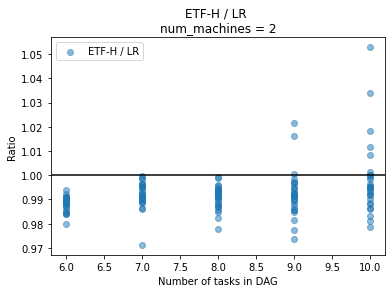

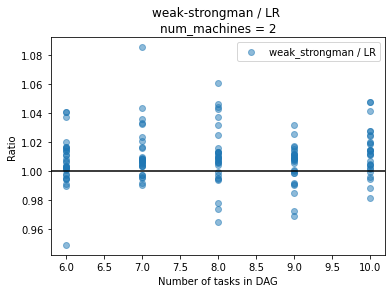

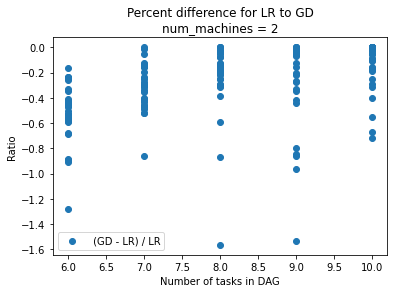

finished with 2 machines


In [9]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
graph_type = "small_dag_100"
training_data_filename = graph_type + "_training_data.csv"
testing_data_filename = graph_type + "_testing_data.csv"
num_machines_lst = [2]

for num_machines in num_machines_lst:
    df_train = create_dataset(num_machines, training_data_filename)
    df_train_results, lr_coefficients, gd_coefficients = train_model(df_train)
    print("LR: " + str(lr_coefficients))
    print("GD: " + str(gd_coefficients))
    #display(df_train_results)

    # ---

    df_test = test_model(num_machines, testing_data_filename, lr_coefficients, gd_coefficients)
    #display(df_test)

    plt.scatter(df_test["num_tasks"], df_test["ETF-H_cost"]  / df_test["LR_cost"], label='ETF-H / LR', alpha=0.5)
    plt.axhline(1,c="k")
    plt.title("ETF-H / LR \nnum_machines = " + str(num_machines))
    plt.xlabel("Number of tasks in DAG")
    plt.ylabel("Ratio")
    plt.legend()
    plt.show()

    plt.scatter(df_test["num_tasks"], df_test["weak_strongman_cost"] / df_test["LR_cost"] , label='weak_strongman / LR', alpha=0.5)
    plt.axhline(1,c="k")
    plt.title("weak-strongman / LR \nnum_machines = " + str(num_machines))
    plt.xlabel("Number of tasks in DAG")
    plt.ylabel("Ratio")
    plt.legend()
    plt.show()

    plt.scatter(df_test["num_tasks"], (df_test["GD_cost"]- df_test["LR_cost"] ) / df_test["LR_cost"] * 100, label=' (GD - LR) / LR')
    plt.title("Percent difference for LR to GD\nnum_machines = " + str(num_machines))
    plt.xlabel("Number of tasks in DAG")
    plt.ylabel("Ratio")
    plt.legend()
    plt.show()
    

    now = datetime.now() # current date and time
    date_time = now.strftime("%m%d%Y_%H%M%S")
    
    df_test.to_csv(graph_type + "_" + str(num_machines) + "_" + str(date_time) + ".csv")
    print("finished with " + str(num_machines) + " machines")

### 